<a href="https://colab.research.google.com/github/GiX7000/computer-vision-on-CIFAR-10-from-basics-to-transformers/blob/main/1_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up directories and download CIFAR-10 dataset in Drive

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# This prints the current working directory.
import os
print('Current working directory: ', os.getcwd())

Current working directory:  /content


In [ ]:
# Using Linux commands like `pwd`, `cd` and `ls`, we ensure project's path.
!ls /content/drive/MyDrive

lab_0_2024_2025  lab_1_2024_2025


In [ ]:
# Project's location path to `FOLDERPATH` variable.
FOLDERPATH = '/content/drive/MyDrive'
assert FOLDERPATH is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that the Python interpreter of the Colab VM can load python files from within it.
import sys
sys.path.insert(1, FOLDERPATH)

In [ ]:
# This downloads CIFAR-10 dataset to our Drive, if it doesn't already exist.
%cd {FOLDERPATH + '/engine/datasets'}
!bash get_datasets.sh "cifar-10-batches-py"

In [ ]:
# Move the dataset to the notebook's folder after downloading.
import shutil
shutil.move(FOLDERPATH + '/engine/datasets/cifar-10-batches-py', '/content/drive/MyDrive')

'/content/drive/MyDrive/labs/cifar-10-batches-py'

In [ ]:
# Verify the dataset is now in the `labs/` folder
!ls /content/drive/MyDrive

cifar-10-batches-py  lab_0_2024_2025  lab_1_2024_2025


In [ ]:
# Having downloaded the dataset, let's change to project's directory
%cd {FOLDERPATH}

/content/drive/MyDrive/labs/lab_1_2024_2025


Find below the desired file structure:

```
labs
├── cifar-10-batches-py
│   ├── batches.meta
│   ├── ...
│   ├── test_batch
├── lab_0_2024_2025
│   ├── convolution.jpeg
│   ├── ...
│   ├── numerical_python_2.ipynb
├── lab_1_2024_2025
│   ├── engine
│   │   ├── classifiers/
│   │   ├── datasets/
│   │   ├── ...
│   ├── knn.ipynb
│   ├── ...
```

Our file structure is like that. There is no need to run the above cells again in the future for the next notebooks. For convenience, we will save the images as numpy arrays.

# k-Nearest Neighbor (k-NN)

## Run setup code

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# This prints the current working directory.
import os
print('Current working directory: ', os.getcwd())

Current working directory:  /content


In [ ]:
# This should be the location of our project's path.
FOLDERPATH = '/content/drive/MyDrive'
assert FOLDERPATH is not None, "[!] Enter the foldername."

# Having downloaded the dataset, let's change to project's directory.
%cd {FOLDERPATH}

/content/drive/MyDrive/labs/lab_1_2024_2025


In [ ]:
# Run some setup code for this notebook.
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules; see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython.
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Pre-processing

In [ ]:
from engine.data_utils import load_CIFAR10

# Load the raw CIFAR-10 data.
cifar10_dir = '/content/drive/MyDrive/labs/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue).
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


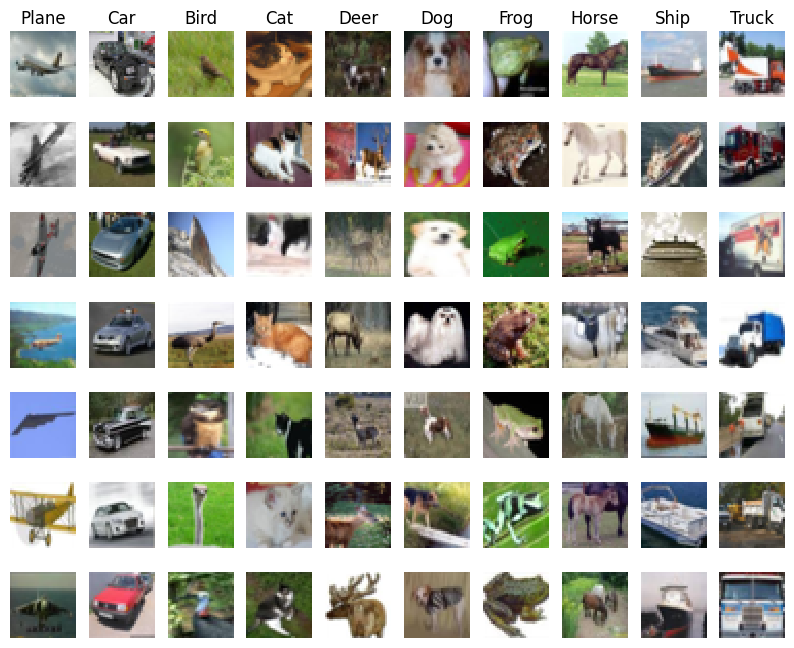

In [ ]:
# Visualize some examples from the dataset (few examples of training images from each class).
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls[:7])
plt.show()

Due to computation limitations, we choose to subsample the data for more efficient code execution. We choose to keep only ``5000`` images for training and ``500`` images for testing. We also reshape the ``3-dimensional`` *tensor* data to ``1-dimensional`` *vector* data. This is a preparation step for the k-NN classification we are about to run below.

In [ ]:
# Subsample the data for more efficient code execution in this exercise.
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Convert arrays uint8 -> float.
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Reshape the image data into rows.
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


We can save these arrays (X_train, y_train, X_test, y_test) in a file format called ``.npy`` (numpy array), so that in case our runtime crashes, we can easily load them again WITHOUT having to load the whole dataset again. Let's have a look on how to do that!

In [ ]:
# First, let's create a new folder called arrays
# inside the labs directory. Specify dir:
labs_dir = '/content/drive/MyDrive'
arrays_dir = os.path.join(labs_dir, 'arrays')

# Create arrays directory
if not os.path.exists(arrays_dir):
    os.makedirs(arrays_dir)

# Save arrays in .npy files inside the new arrays dir
np.save(os.path.join(arrays_dir, 'X_train_knn.npy'), X_train)
np.save(os.path.join(arrays_dir, 'y_train_knn.npy'), y_train)
np.save(os.path.join(arrays_dir, 'X_test_knn.npy'), X_test)
np.save(os.path.join(arrays_dir, 'y_test_knn.npy'), y_test)

# Check that arrays are indeed saved
os.listdir(arrays_dir)

['X_train_knn.npy', 'y_test_knn.npy', 'y_train_knn.npy', 'X_test_knn.npy']

## Load .npy files

Now, we can use the following coding snippet in case the runtime crashes to easily load these arrays.

In [ ]:
# Specify labs dir again, so that arrays dir is
# automatically retrieved and arrays can be loaded from it
labs_dir = '/content/drive/MyDrive'
arrays_dir = os.path.join(labs_dir, 'arrays')

# Load arrays if needed. Uncomment to use!
X_train = np.load(os.path.join(arrays_dir, 'X_train_knn.npy'))
y_train = np.load(os.path.join(arrays_dir, 'y_train_knn.npy'))
X_test = np.load(os.path.join(arrays_dir, 'X_test_knn.npy'))
y_test = np.load(os.path.join(arrays_dir, 'y_test_knn.npy'))

# Num of samples for training and test
num_training = X_train.shape[0]
num_test = X_test.shape[0]

## Train k-NN classifier, Compute distance (two loops)

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In [ ]:
from engine.classifiers.k_nearest_neighbor import KNearestNeighbor

# Create a kNN classifier instance. Remember that training a kNN classifier is a noop: the Classifier simply remembers the data and does no further processing.
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances (no use of np.linalg.norm()) between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are ``Ntr`` training examples and ``Nte`` test examples, this stage should result in a ``Nte x Ntr`` matrix where each element ``(i,j)`` is the distance between the ``i-th`` test and ``j-th`` train example.

We implement the function `compute_distances_two_loops` in `engine/classifiers/k_nearest_neighbor.py` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [ ]:
# After implementing it in engine/classifiers/k_nearest_neighbor.py, we test our implementation.
dists_two = classifier.compute_distances_two_loops(X_test)
print(dists_two.shape)

(500, 5000)


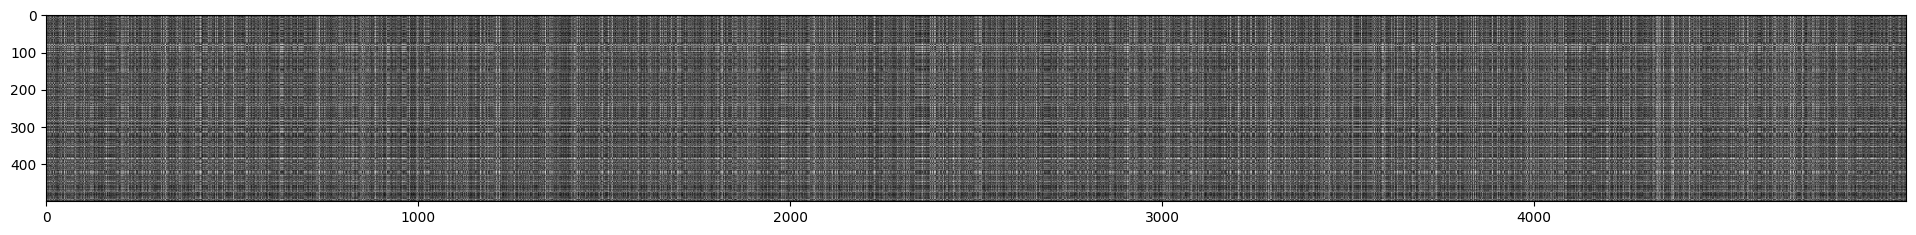

In [ ]:
# We can also visualize the distance matrix: each row is a single test example and its distances to training examples.
f = plt.figure(figsize=(24,4))
plt.imshow(dists_two, interpolation='none')

The shape of the distance matrix is (500, 5000), where each row represents the distances of a sample in the test set from every sample in training set and each column represents the distances of a sample in the training set from all points in the test set, respectively. Each point in the dists matrix corresponds o the L2 distance, so if the distance between i-th test and j-th training points is high the color is brighter and represents the disimilarity between the points, while if the distance between the points is low, the points are closer and the color is darker, which reveals the similarity between the points. Thus, a dark row means that this test point is very similar to the most of training points and a bright row declares that this test point is disimilar to most of training points. Likewise, when column is dark, we have this training point to be verey similar to most of the samples in test set and, when a column is bright means that this training point is away from most of test points. Generally, how dark or bright is a row or column reflects to how similar or disimilar a data point is(either if it is in training or test set) compared to the other dataset.

## Predict Labels

$\color{pink}{\textit Code Question:}$

We also implement the function `predict_labels` in `engine/classifiers/k_nearest_neighbor.py`. This function should take as input the distance matrix between test and training points and output a label for each test point.

In [ ]:
# Implement the function predict_labels (use k = 1) and run the code below.
y_test_pred = classifier.predict_labels(dists_two, k=1)

# Compute and print the fraction of correctly predicted examples.
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


We get approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [ ]:
y_test_pred = classifier.predict_labels(dists_two, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


We get a slightly better performance than with `k = 1`, as expected!

Apart from L2 distance, we can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,
the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$

The general standard deviation $\sigma$ is defined similarly.

Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$) will not change the performance of the k-Neirest Neighbor classifier, as the mean from all pixel values will just shift all the points in the feature space by the same amount. Even if the absolute pixel values change by the mean for each point, the distances between points will remain unchanged. Mathematically:

$$\ L1=\sum_{i,j}\lvert({p}_{ij}^{(k)}-\mu)-({p}_{ij}^{(l)}-\mu)\lvert=\sum_{i,j}\lvert\tilde{p}_{ij}^{(k)}-\tilde{p}_{ij}^{(l)}\lvert$$

Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$ not only pixel values change, but the distance between points changes, too. So, L1 distance changes and this influences the performance of the classifier, which is usually becoming better(normalization/standardization technique). Mathematically:

$$\ L1=\sum_{i,j}\lvert\frac{({p}_{ij}^{(k)}-\mu)}{\sigma}-\frac{({p}_{ij}^{(l)}-\mu)}{\sigma}\lvert=\frac{\sum_{i,j}\lvert\tilde{p}_{ij}^{(k)}-\tilde{p}_{ij}^{(l)}\lvert}{\sigma}$$


## Compute distance (one loop)

In `engine/classifiers/k_nearest_neighbor.py`, we implement the function `compute_distances_one_loop` that uses partial vectorization with one loop to speed up the distance matrix computation.

In [ ]:
# Now lets speed up distance matrix computation by using partial vectorization with one loop. We implement the function compute_distances_one_loop and run the code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it agrees with the naive implementation. There are many ways to decide whether two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square root of the squared sum of differences of all elements; in other words, reshape the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists_two - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


## Compute distance (no loops)

Again in `engine/classifiers/k_nearest_neighbor.py`, we implement the function `compute_distances_no_loops` that uses the fully vectorized version.

In [ ]:
# Now implement the fully vectorized version inside compute_distances_no_loops and run the code.
dists = classifier.compute_distances_no_loops(X_test)

# Check that the distance matrix agrees with the one we computed before.
difference = np.linalg.norm(dists_two - dists, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [ ]:
# Let's compare how fast the implementations are.
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# Expected significantly faster performance with the fully vectorized implementation!

Two loop version took 36.987941 seconds
One loop version took 36.935165 seconds
No loop version took 0.576689 seconds


## k-fold cross validation

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value ``k = 5`` arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

We split up the training data into folds and perform k-fold cross validation to find the best value of ``k``.

In [ ]:
# Split up the training data into folds. After splitting, X_train_folds and y_train_folds should each be lists of length num_folds, where y_train_folds[i] is the label vector for the points in X_train_folds[i].
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# A dictionary holding the accuracies for different values of k that we find when running cross-validation. After running cross-validation, k_to_accuracies[k] should be a list of length num_folds giving the different accuracy values that we found when using that value of k.
k_to_accuracies = {}

# Perform k-fold cross validation to find the best value of k. For each possible value of k, run the k-nearest-neighbor algorithm num_folds times, where in each case you use all but one of the folds as training data and the last fold as a validation set. Store the accuracies for all fold and all values of k in the k_to_accuracies dictionary.
for k in k_choices:
    for i in range(num_folds):

      # Set a validation set for i-th fold.
      X_val = X_train_folds[i]
      y_val = y_train_folds[i]

      # Set the remaining folds as training set by excluding the validation fold.
      X_train_fold = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:])
      y_train_fold = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:])

      # Train and evaluate the k-classifier.
      classifier = KNearestNeighbor()
      classifier.train(X_train_fold, y_train_fold)
      y_val_pred = classifier.predict(X_val, k=k)

      # Calculate the classifier's accuracy.
      num_correct = np.sum(y_val_pred == y_val)
      accuracy = (num_correct) / len(y_val)

      # Add k and its accuracy to dictionary.
      if k in k_to_accuracies:
        k_to_accuracies[k].append(accuracy)
      else:
        k_to_accuracies[k] = [accuracy]

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

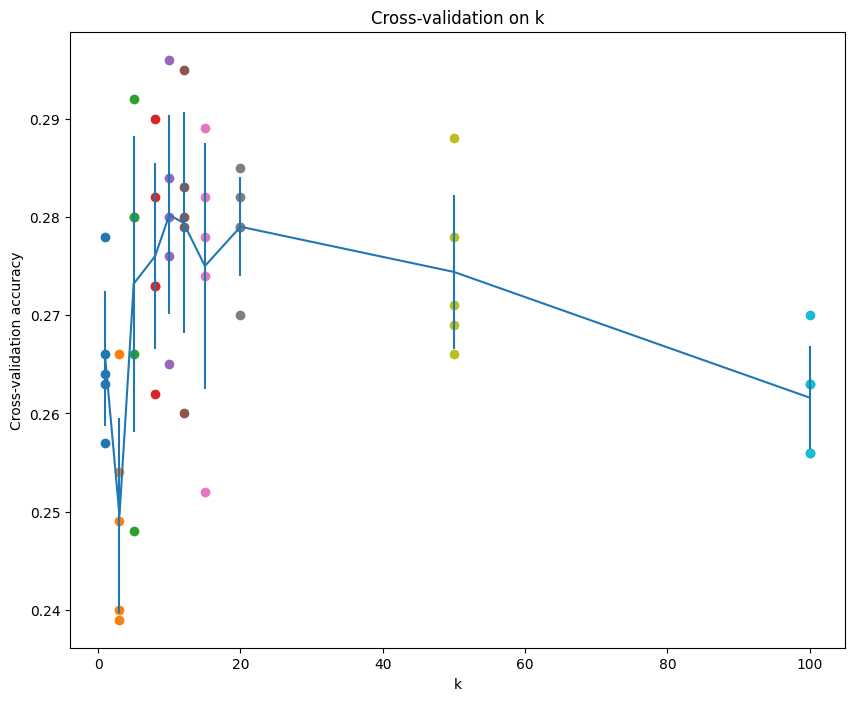

In [ ]:
# Plot the raw observations.
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# Plot the trend line with error bars that correspond to standard deviation.
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k, retrain the classifier using all the training data, and test it on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy.
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


Some general thoughts:

Generally, the decision boundary of the k-NN classifier is generally non-linear.

When training error of a 1-NN, knn just memorizes all the training points, so, as k increases training error increases, beacause the classifier will base its predictions on more than one neighbors.

Test error of a 1-NN is always higher than whatever k>1, beacause a 1-NN perfectly fits the training data(just memorizes it), so for a new unseen given point, it won't generalize(1-NN overfits).

As  we see earlier in the notebook, finding nearest neighbors requires the calculation of the distances of each test point from all training points. So, if by increasiing the training set, the time to calculate the distances increases increases and the time to classify a test example, too.


Next, we will randomly select one image from each of the 10 classes in the CIFAR-10 test set. Using the k-Nearest Neighbor classifier, we will find and display the top-10 closest images from the training set for each selected image. We will apply the following conditions:

- For each selected test image, we display the 10 closest images based on their distances in the feature space.
- Below each image, display its predicted class.
- We apply a green border if the retrieved image belongs to the same class as the test image (i.e., correctly retrieved), and a red border otherwise (i.e., incorrectly retrieved).
  
This task allows us to visually inspect how well the k-NN classifier performs in "retrieving" images.

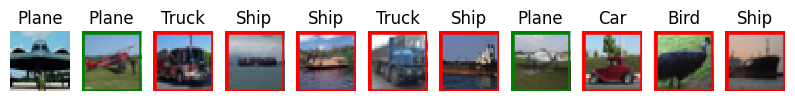

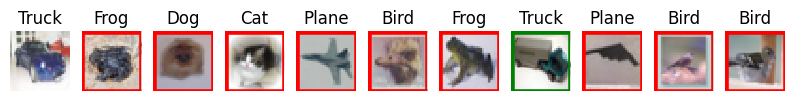

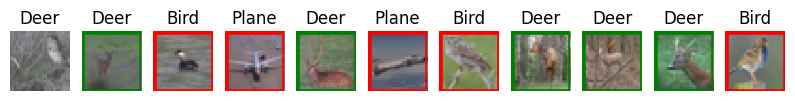

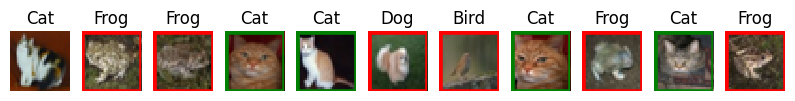

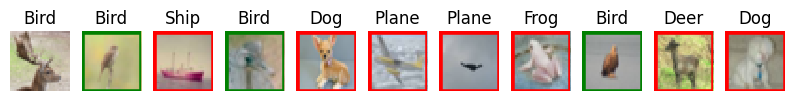

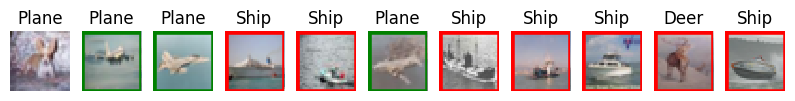

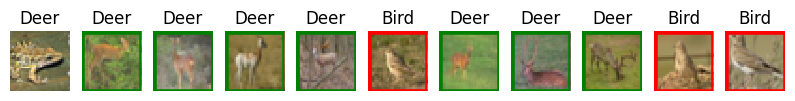

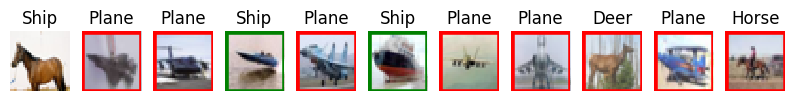

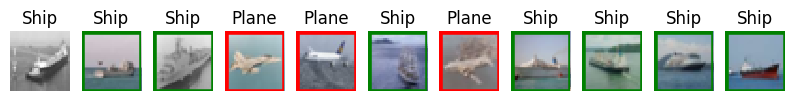

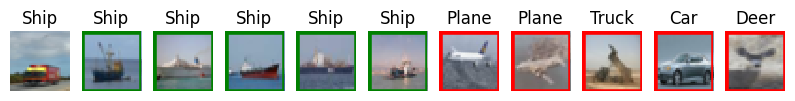

In [ ]:
# Visualize the top-10 closest images to a randomly chosen image from each class in the CIFAR-10 test set. For each class, select one random test image and find the 10 closest training images. Use the distances to color-code the retrieved images with a green border for correct labels and red for incorrect ones.

# Visualization function that takes as input only the L1 and L2 distances(because below, we will use it again).
def visualize_nearest_neighbors(dists):
  # Select one random test image per class based on its actual class, so 10 in total.
  test_image_indices = []
  for idx in range(len(classes)):
    class_indices = np.where(y_test == idx)[0]
    test_image_indices.append(np.random.choice(class_indices))

  # For the above random selection, retrieve image, predicted label and the 10 closest training images with their labels.
  for test_idx in test_image_indices:
    test_image = X_test[test_idx].reshape(32, 32, 3).astype('uint8')  # Reshape for display.
    predicted_label = int(y_test_pred[test_idx])  # Take the prediction labels for the random selected images(indices).
    distances = dists[test_idx] # dists is already calculated above.
    closest_indices = np.argsort(distances)[:10]  # Get indices of the 10 closest images.
    closest_images = X_train[closest_indices]
    closest_labels = y_train[closest_indices]

    # Display the random selected test images in the first column of subplot grid.
    ax = plt.subplot(1, 11, 1)
    ax.imshow(test_image)
    ax.set_title(classes[predicted_label])
    ax.axis('off')

    # Display each of these 10 closest training images.
    for i, (train_idx, neighbor_label) in enumerate(zip(closest_indices, closest_labels)):
      neighbor_image = X_train[train_idx].reshape(32, 32, 3).astype('uint8')  # Reshape for display.

      # Check if the label of the closest image matches to the label of the selected test image.
      is_correct = neighbor_label == predicted_label

      # Display the neighbor image with color-coded border.
      ax = plt.subplot(1, 11, i + 2)
      ax.imshow(neighbor_image)
      ax.set_title(classes[neighbor_label])
      ax.axis('off')

      # Set border colors to green for correct and red for incorrect.
      border_color = "green" if is_correct else "red"
      rect = plt.Rectangle((0, 0), 32, 32, linewidth=4, edgecolor=border_color, facecolor="none")
      ax.add_patch(rect)

    plt.show()

# Plot 10 random selected test imeages and their 10 closest images from training set.
visualize_nearest_neighbors(dists)

In the previous visualization, we examined how well k-NN using L2 distance “retrieves” the top-10 closest images to a randomly selected image from each class. In a k-NN classification scenario where k=10, the algorithm would assign the test image to the class that appears most frequently among the retrieved images.

Some thoughts on qualitatively evaluation on the results:

1. Retrieval can fail due to:

*   Morphologically similarities, in which the content of an image of one class looks very similar to the content of another image of a different class. For example, in the above results, images with deers are very similar with images of cats and dogs(a dog and a cat might look morphologically similar if they have the same size, body, shape or pose, even though their species are different), or planes with ships respectively and, thus, they can incorrectly classified at the same class.
*   Background. Here, images with blue background, which can represent sea or sky, can be misclassified, especially for the classes of planes and ships. The same happens on classes of animals, because animals can be in very similar green environments/background. So, background can heavily influence the model's predictionand drives it to failure.
*   Viewpoint. A specific pose of a car can classified as a truck or there are cases in which a viewpoint of a ship be very similar to a plane. So, changes in pose, viewpoint can cause the model to retrieve incorrect class for images.

2. Retrieval succeeds when:

*   we have objects with very similar morphological features like most animals have(cats, dogs) or vehicles (like cars and trucks). So, they share same common characteristics and shapes. In these cases, knn can effectively identify correct classes.

*   we have similar visual patterns. For example, different birds with similar colors and background can be all classified as birds. The same for cars or ships, etc.

*   we have objects that look very different from each other, like frog vs. ship or plane vs. cat, etc. In these cases, pixel value differences are too large, so it is easy for the knn classifier to do the job, even if background and viewpoint make it harder.

3. L2 distance measures similarity based on the pixel values, which are often not sufficient to capture the true semantic meaning of an image in the real world. So, the classifier doesn't understand what objects or background are in the image. For example, the color density, especially in backgrounds, causes the model to predict a plane as a ship due to the colored background. Apart from that, the classifier can also fail when two objects like cat and dog, due to their similar shape or pattern, can be classified to the same class or a white car can be classified as a white ship due to a specific pose or viepoint of the car. So, the classifier misses the meaning/semantic of the image each time(feature or object). And this is very reasonable as it focuses on surface details(=abstract concepts) by measuring pixel distances.

Generally, L2 distance focuses on superficial features(colors, textures, shapes, etc) rather than more specific features(object type, shape, scene context, etc). To improve the semantic understanding of an imagae, we should use more advanced methods like CNNs!








In the current implementation, the `compute_distances_two_loops()` function calculates the L2 distance between each test point and each training point. We modify the function inside `engine/classifiers/k_nearest_neighbor.py` to use the L1 distance (also known as Manhattan or taxicab distance) instead of L2.

This requires computing the sum of the absolute differences between corresponding elements of the two points.

In [ ]:
# Having implemented compute_distances_two_loops function in engine/classifiers/k_nearest_neighbor.py we test our implementation.
dists_two_L1 = classifier.compute_distances_two_loops_L1(X_test)
print(dists_two.shape)

(500, 5000)


In [ ]:
# Now, we run again (k = 1) the function predict_labels.
y_test_pred = classifier.predict_labels(dists_two_L1, k=1)

# Compute and print the fraction of correctly predicted examples.
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 145 / 500 correct => accuracy: 0.290000


We observe that k-NN using L1 distance is performing slightly better.

Having modified the `compute_distances_two_loops()` function, to use L1 distance, we reuse the above visualization function to visualize the top-10 closest images to a randomly chosen image from each class in the CIFAR-10 dataset, as we did previously with L2 distance.

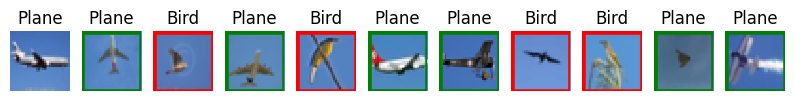

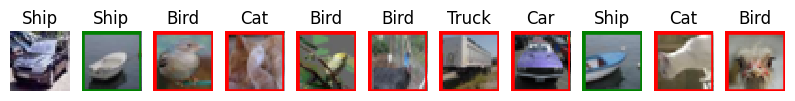

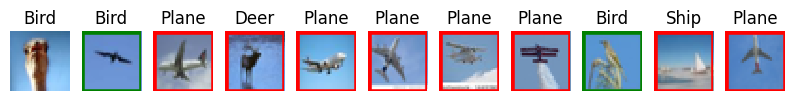

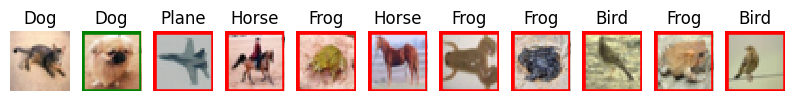

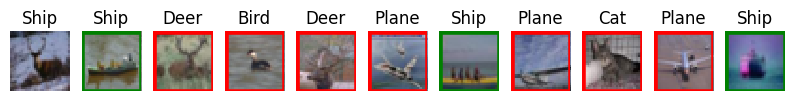

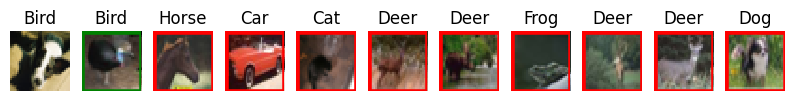

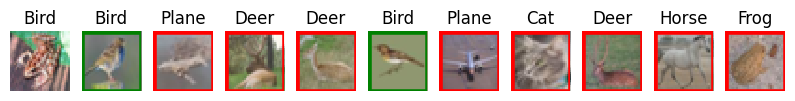

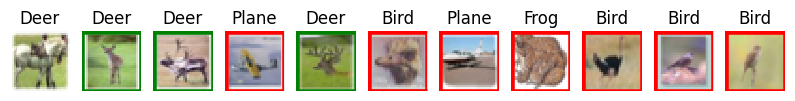

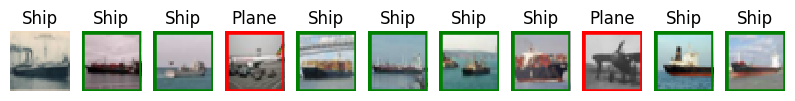

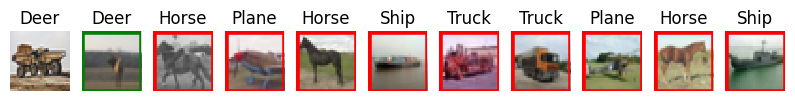

In [ ]:
# Visualize the top-10 closest images to a randomly chosen image from each class in the CIFAR-10 test set. For each class, select one random test image and find the 10 closest training images. Use the distances to color-code the retrieved images with a green border for correct labels and red for incorrect ones.
visualize_nearest_neighbors(dists_two_L1)

After visualizing the top-10 closest images using both L2 and L1 distances, let's compare the results:

First of all, we would like to mention that with L1 distance, we take slightly better results in accuracy(29% in L1 vs. 28.2% in L2), even if in L1 distance we calculated distances with two loops(in the comparing result of L2, where distances are calculated with the no loops method).

*  According to the above results, we can see that
predicted outputs using L1 distance are almost the same as those with L2 distance. There are slight differences and it's also hard to distinguish with a model of almost 29% accuracy. The only observation I can mention is that L1 may be better when we have big shapes and patterns in images like we see above in pictures with ships, planes or frogs. It seems it is harder for a classifier that uses L1 to capture more than the big differences across the images, so a classifier with L1 distance captures more global features. L1 can sometimes retrieve images that are more semantically similar like in 1-th and 9-th rows, where structures and colors vary slightly, so the classifier can easily predict the semantic meaning of the images.

*  Like in 3-th row with deers and in 4-th one with cats in the L2 visualizion, L2 is better when we have zoomed and localized to the object images or different viewpoint. Generally, spicific similarities(characteristics, local structures/shapes, etc) and smaller differences can be better captured by L2 rather than L1. For example in vehicles we have wheels, doors, lights in almost the same place of the shape of the object, L2 can match better(at least, from that things we see above with this low performance model).

In summary, L1 focuses on big differences and captures big similarities. This is very reasonable, beacause in order to find L2, we only use the aboslute distance between the points. On the other hand, L2, due to its way of calculation, emphasizes on more detailed similarities and differences. Therefore, L1 distance might be more appropriate if the goal is to retrieve images with global similarity and L2 might be preferred when focusing on retrieving images with more detailed, morphologically similar features. Finally, I mention it again, otther feature extraction methods are more suitable for deeper semantic understanding and analysis.